[9.021635105010548, 9.913360362446276, 10.346930242075695, 11.504594357928584]
[-inf, 1.1, inf]


/opt/anaconda3/envs/master_proj/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/envs/master_proj/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/master_proj/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/master_proj/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/master_proj/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


['9.57+-0.23', '10.14+-0.12', '10.76+-0.25']
['0.99+-0.09', '1.24+-0.10', 'nan+-nan']


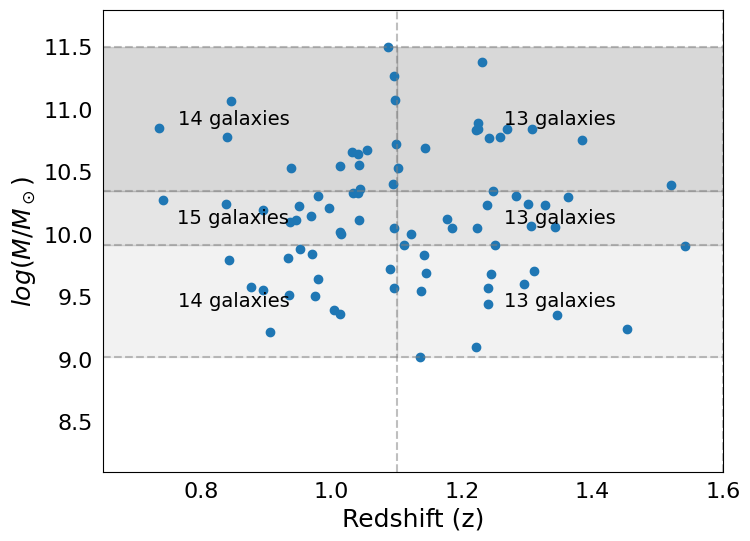

In [1]:
from   astropy.io import fits
import numpy as np
from   astropy.table import Table
import matplotlib.pyplot as plt
from   scripts.tools    import *
from   scripts.hst3d      import *
from   scripts.jwst       import *
obj_lis = Table.read('obj_lis_selected.fits')

select = np.logical_and(np.logical_and(obj_lis['tag']!='agn',obj_lis['manual_select']=='keep'),obj_lis['mass']>0)
select = np.logical_and(obj_lis['manual_select']=='keep',obj_lis['mass']>0)
obj_lis_sel = obj_lis[select]

# Create mass bins with equal number of galaxies
sorted_masses = np.sort(np.log10(obj_lis_sel['mass'][~np.isnan(obj_lis_sel['mass'])]))
bins_m = [sorted_masses[0], sorted_masses[len(sorted_masses) // 3], sorted_masses[2 * len(sorted_masses) // 3], sorted_masses[-1]]
print(bins_m)

# Create labels for the mass bins
bin_label_m = [f'{bins_m[i]:.2f}<logm<{bins_m[i+1]:.2f}' for i in range(len(bins_m) - 1)]
binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)
bins_z  = [-np.inf,1.1,np.inf]
binning_z = np.digitize(obj_lis['z_MAP'],bins_z)
bin_label_m = [r'$8.9<logM/M_\odot<9.8$',r'$9.8<logM/M_\odot<10.35$',r'$10.35<logM/M_\odot<11.5$']
bin_label_z = ['0.6<z<1.1','1.1<z<1.5']
print(bins_z)


obj_lis['bin_m'] = binning_m
obj_lis['bin_z'] = binning_z
obj_lis.write('obj_lis_selected_bins.fits',overwrite=True)


def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

binning_m_sel = binning_m[select]
binning_z_sel = binning_z[select]
std_lis = [np.log10(np.median(obj_lis_sel['mass'][binning_m_sel==i])) for i in range(1,4)]
std_lis_var = [np.std(np.log10(obj_lis_sel['mass'][binning_m_sel==i])) for i in range(1,4)]
print([f'{std_lis[i]:.2f}+-{std_lis_var[i]:.2f}' for i in range(3)])


#check the properties for mass and 
std_lis = [np.median(obj_lis_sel['z_MAP'][binning_z_sel==i]) for i in range(1,4)]
std_lis_var = [np.std(obj_lis_sel['z_MAP'][binning_z_sel==i]) for i in range(1,4)]
print([f'{std_lis[i]:.2f}+-{std_lis_var[i]:.2f}' for i in range(3)])
# Define the bin edges for mass and redshift
mass_bins = bins_m
redshift_bins = [0.6, 1.1, 1.6]

fit = plt.figure(figsize=(8, 6))
# Plot the data points
plt.plot(obj_lis_sel['z_MAP'], np.log10(obj_lis_sel['mass']), 'o')

# Add vertical lines for redshift bins
for z in redshift_bins:
    plt.axvline(z, color='grey', linestyle='--', alpha=0.5)

# Add horizontal lines for mass bins
for m in mass_bins:
    plt.axhline(m, color='grey', linestyle='--', alpha=0.5)

# Add shaded regions for each bin and annotate the number of data points
for i in range(len(redshift_bins) - 1):
    for j in range(len(mass_bins) - 1):
        bin_mask = (obj_lis_sel['z_MAP'] >= redshift_bins[i]) & (obj_lis_sel['z_MAP'] < redshift_bins[i + 1]) & (np.log10(obj_lis_sel['mass']) >= mass_bins[j]) & (np.log10(obj_lis_sel['mass']) < mass_bins[j + 1])
        num_points = np.sum(bin_mask)
        plt.fill_betweenx([mass_bins[j], mass_bins[j + 1]], redshift_bins[i], redshift_bins[i + 1], color='grey', alpha=0.1 * (j + 1))
        plt.text((redshift_bins[i] + redshift_bins[i + 1]) / 2, (mass_bins[j] + mass_bins[j + 1]) / 2, f'{num_points} galaxies', color='black', ha='center', va='center', fontsize=14)
#display no tick lines in the plot
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=True, labelleft=True)
#make x,y axis lablel big
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(8.1, 11.8)
plt.xlim(0.65, 1.6)
plt.xlabel('Redshift (z)', fontsize=18)
plt.ylabel(r'$log(M/M_\odot)$', fontsize=18)
#plt.savefig('image_outputs/mass_redshift_bins.png')
plt.show()



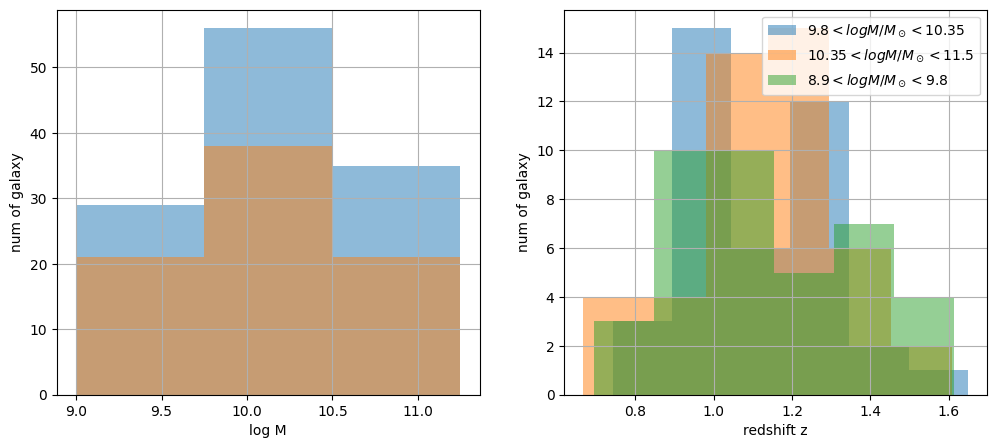

In [2]:
ax = plt.figure(figsize=(12,5))
ax.add_subplot(121)
plt.hist(np.log10(obj_lis['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)
plt.hist(np.log10(obj_lis_sel['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)
plt.xlabel('log M');plt.ylabel('num of galaxy')
plt.grid()

ax.add_subplot(122)
plt.hist(obj_lis[binning_m==2]['z_MAP'],bins=6,alpha=0.5,label=bin_label_m[1])
plt.hist(obj_lis[binning_m==3]['z_MAP'],bins=6,alpha=0.5,label=bin_label_m[2])
plt.hist(obj_lis[binning_m==1]['z_MAP'],bins=6,alpha=0.5,label=bin_label_m[0])

plt.xlabel('redshift z');plt.ylabel('num of galaxy')
plt.legend();plt.grid()
plt.show()

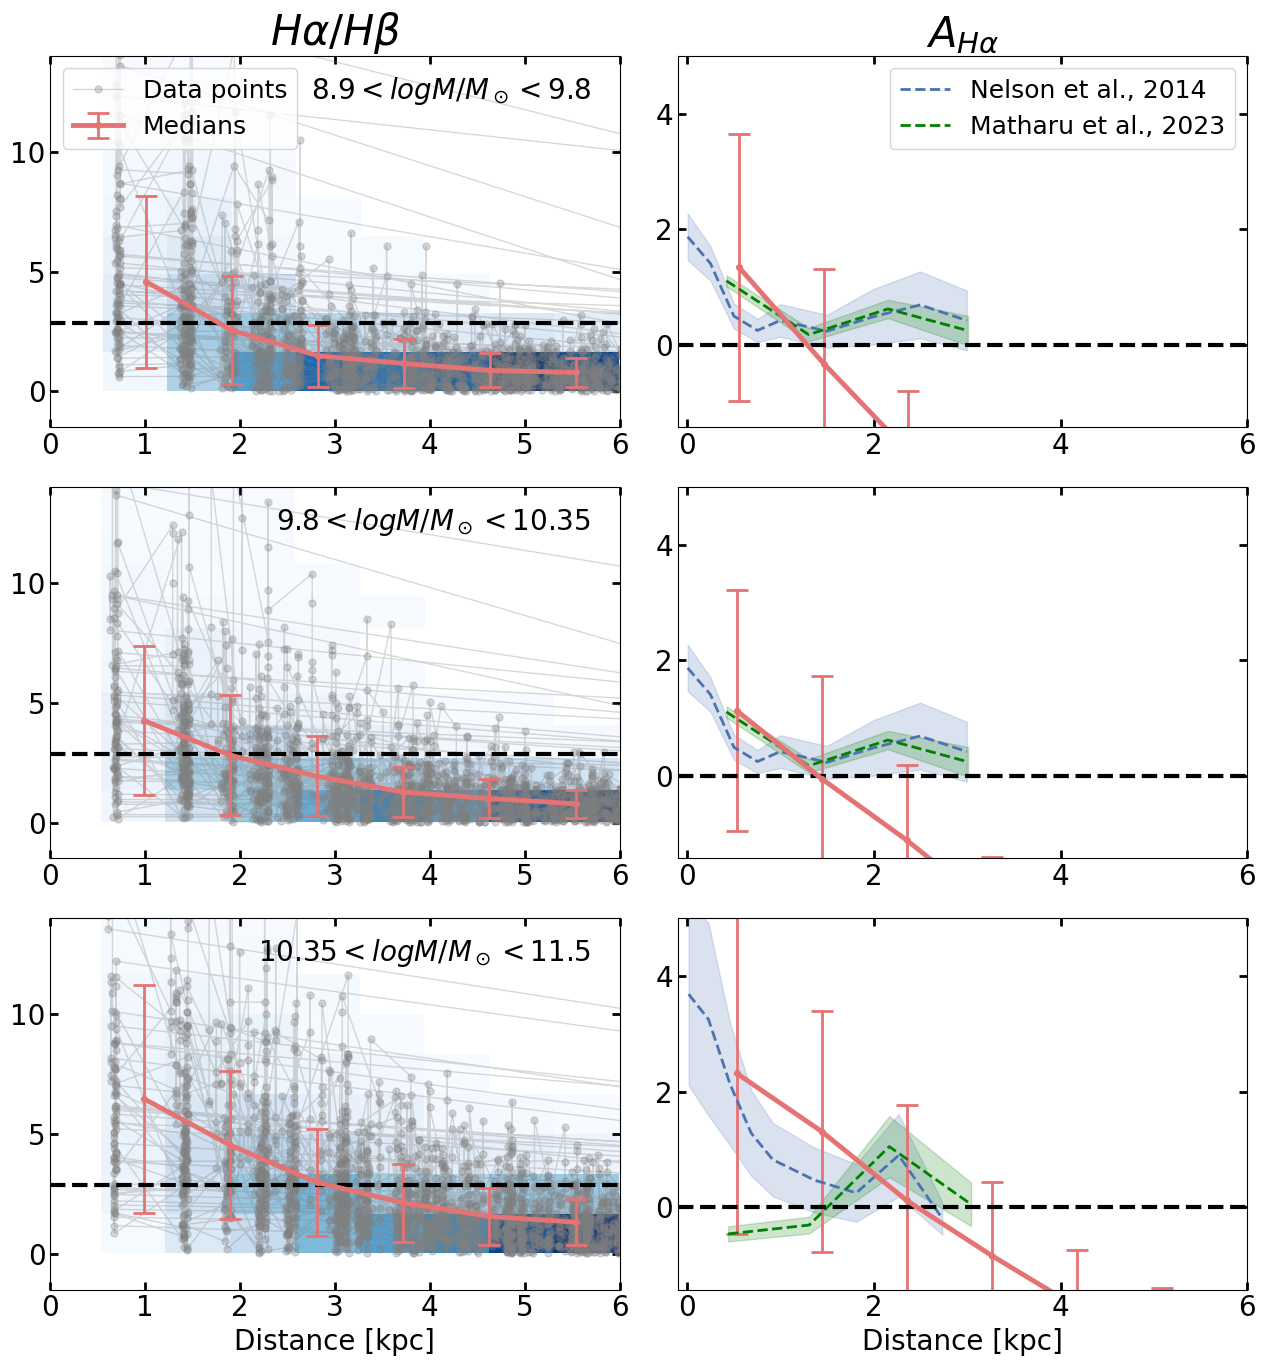

In [7]:
# ============================== Part 1: Data Preparation and Plotting ==============================
obj_lis_sel = obj_lis[select]
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(13, 14))  # 调整为适合3x2布局的尺寸

# --------------------------- 初始化存储列表 ---------------------------
binned_radius = []
median_balmer = []
median_balmer_err = []

# ============================== 主处理循环 ==============================
for i in range(len(bins_m) - 1):
    # ===================== 左列：原始数据分布图 =====================
    ax_left = fig.add_subplot(3, 2, i*2+1)  # 左列位置：1,3,5
    ax_left.tick_params(direction='in', which='both', top=True, right=True, width=2, length=6, labelsize=20)  # Set tick width, length, and label size

    # ----------------- 数据加载与预处理 -----------------
    r_lis = np.array([])
    balmer_lis = np.array([])
    balmer_err_lis = np.array([])

    for obj in obj_lis_sel[binning_m_sel == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        #with fits.open(path) as hdu:
        #data = find_data('RAD_PROFILE_ELLIP__CONV_PACK', hdu)[1].data
        #r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
                    # Extract and plot the radial profiles
        table = Table.read(f"data_extracted/{file_name(obj, prefix='rad')}")

        sn_threshold= 0
        
        mask1 = table['ha']/table['ha_err'] > sn_threshold
        mask2 = table['hb']/table['hb_err'] > sn_threshold
        mask = np.logical_and(mask1,mask2)
        table = table[mask]
        r = table['DISTANCE [kpc]']
        ha_r = table['ha']
        ha_r_err = table['ha_err']
        hb_r = table['hb']
        hb_r_err = table['hb_err']
        balmer_r = table['ha']/table['ha_err']
        balmer_r_err = table['balmer_err']

        A_Ha = -2.5 * np.log10(ha_r / hb_r)


        r_lis = np.append(r_lis, r)
        balmer_lis = np.append(balmer_lis, balmer_r)
        balmer_err_lis = np.append(balmer_err_lis, balmer_r_err)

    # ----------------- 可视化部分 -----------------
    r_bins_center = bin_center(r_lis)
    mask = np.logical_and(r_lis < 6, balmer_lis < 1e100)
    mask_for_plot = np.logical_and(r_lis < 6, balmer_lis < 20)

    # 2D直方图
    hist = ax_left.hist2d(r_lis[mask_for_plot], balmer_lis[mask_for_plot], 
                         bins=(8, 12), cmap='Blues', cmin=1)
    #plt.colorbar(hist[3], ax=ax_left)
    
    # 原始数据点
    ax_left.plot(r_bins_center, balmer_lis, 
                linewidth=1, marker='o', markersize=5, 
                color='grey', alpha=0.3, label='Data points')
    
    # 分箱中值计算
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=7)
    bin_indices = np.digitize(r_lis[mask], bin_edges)
    median_values = [np.mean(balmer_lis[mask][bin_indices == j]) 
                    for j in range(1, len(bin_edges))]
    std_values = [np.std(balmer_lis[mask][bin_indices == j]) 
                 for j in range(1, len(bin_edges))]
    std_r_values = [np.std(r_lis[mask][bin_indices==j]) 
                  for j in range(1,len(bin_edges))]

    # 中值误差棒
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax_left.errorbar(bin_centers, median_values, yerr=std_values,# xerr=std_r_values,
                    fmt='-', color="#E57373", alpha=1, linewidth=3.5,
                    marker='o', markersize=4, label='Medians', elinewidth=2,capsize=8,capthick=2)

    # 公共元素
    ax_left.axhline(2.86, 0, 7, linestyle='--', color='black',linewidth=3)
    ax_left.set_xlim(0,6)
    ax_left.set_ylim(-1.5,14)
    if i==2:
        ax_left.set_xlabel('Distance [kpc]',fontsize=20)
    ax_left.text(0.95, 0.95, [r'$8.9<logM/M_\odot<9.8$',r'$9.8<logM/M_\odot<10.35$',r'$10.35<logM/M_\odot<11.5$'][i], transform=ax_left.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right')
    
    if i == 0:
        ax_left.set_title(r'$H\alpha/H\beta$', fontsize=30)
        ax_left.legend(loc='upper left',fontsize=18)

    # ===================== 存储中间结果 =====================
    binned_radius.append(bin_edges[:-1])
    median_balmer.append(median_values)
    median_balmer_err.append(std_values)

def K_lambda(line='Ha'):
    """
    Calculate the dust attenuation value k(lambda) from the Calzetti et al. (2000) attenuation curve
    for either H-alpha (656.3 nm) or H-beta (486.1 nm).
    
    Parameters:
        line (str): 'Ha' for H-alpha (656.3 nm) or 'Hb' for H-beta (486.1 nm).
        
    Returns:
        float: Attenuation value k(λ)
    """
    if line == 'Ha':
        wavelength_um = 0.6563  # Hα (656.3 nm)
    elif line == 'Hb':
        wavelength_um = 0.4861  # Hβ (486.1 nm)
    else:
        raise ValueError("Invalid input! Use 'Ha' for H-alpha or 'Hb' for H-beta.")

    if 0.12 <= wavelength_um <= 0.63:
        # UV to optical range (Calzetti 2000)
        k_lambda = 2.659 * (-2.156 + 1.509 / wavelength_um - 0.198 / (wavelength_um ** 2) + 0.011 / (wavelength_um ** 3)) + 4.05
    elif 0.63 < wavelength_um <= 2.2:
        # Near-Infrared range (Calzetti 2000)
        k_lambda = 2.659 * (-1.857 + 1.040 / wavelength_um) + 4.05
    else:
        raise ValueError("Wavelength out of range (0.12 - 2.2 μm).")

    return k_lambda

def calculate_attenuation(data_array):
    return 2.5*np.log10(np.array(data_array)/2.86)/(K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')

def calculate_attenuation_err(error_array):
    #uses errorpropagation formula for log10
    return 2.5*np.log10(1+np.array(error_array)/2.86)/(K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')
# ============================== 第二部分：对比分析 ==============================
plt.rcParams.update({'font.size': 18})
hst3d_label = ['LogM=[9.0,9.2]', 'LogM=[9.2,9.8]', 'LogM=[9.8,11]']
jwst_label = ['LogM=[7.6,9.0]', 'LogM=[9.0,10.0]', 'LogM=[10.0,11]']

for i in range(len(bins_m) - 1):
    # ===================== 右列：文献对比图 =====================
    ax_right = fig.add_subplot(3, 2, i*2+2)  # 右列位置：2,4,6
    ax_right.tick_params(direction='in', which='both', top=True, right=True, width=2, length=6, labelsize=20)  # Set tick width and length
    
    # ----------------- 当前研究结果 -----------------
    r = binned_radius[i]
    median = median_balmer[i]
    std = median_balmer_err[i]
    
    ax_right.errorbar(r, calculate_attenuation(median),
                      yerr=calculate_attenuation_err(std), 
                      #xerr= std_r_values,
                     fmt='-', color="#E57373", alpha=1, 
                     linewidth=3.5, marker='o', markersize=4, 
                     elinewidth=2,capsize=8,capthick=2)

    
    # ----------------- 文献数据 -----------------
    # 3D-HST数据
    r_theo1, balmer_theo1, balmer_err_theo1 = hst3d_result(['middle', 'middle', 'high'][i])
    balmer_theo1 = calculate_attenuation(balmer_theo1)
    balmer_err_theo1 = calculate_attenuation_err(balmer_err_theo1)
    if i == 0:
        index = 1
    else:
        index = i
    ax_right.plot(r_theo1, balmer_theo1, marker=None, linestyle='--', linewidth=2,
                 color="#4C72B0", label='Nelson et al., 2014')#f'3D-HST\nz~1.4\n{hst3d_label[index]}')
    ax_right.fill_between(r_theo1, 
                         balmer_theo1 - balmer_err_theo1,
                         balmer_theo1 + balmer_err_theo1,
                         color="#4C72B0", alpha=0.2)
    
    # JWST数据
    r_theo2, balmer_theo2, balmer_err_theo2 = jwst_result(['middle', 'middle', 'high'][i])
    balmer_theo2     = calculate_attenuation(balmer_theo2)
    balmer_err_theo2 = calculate_attenuation_err(balmer_err_theo2)
    ax_right.plot(r_theo2, balmer_theo2, marker=None, linestyle='--',
                 color="g", linewidth=2, 
                 label='Matharu et al., 2023')#f'JWST\nz:[1.0,1.7]\n{jwst_label[index]}')
    ax_right.fill_between(r_theo2, 
                         balmer_theo2 - balmer_err_theo2,
                         balmer_theo2 + balmer_err_theo2,
                         color="g", alpha=0.2)
   # ax_right.text(0.95, 0.95, [r'$8.9<logM/M_\odot<9.8$',r'$9.8<logM/M_\odot<10.35$',r'$10.35<logM/M_\odot<11.5$'][i], transform=ax_left.transAxes, fontsize=17, verticalalignment='top', horizontalalignment='right')

    # ----------------- 公共元素 -----------------
    if i==0:
        ax_right.set_title(r'$A_{H\alpha}$',fontsize=30)
        ax_right.legend(fontsize=18, loc='upper right')
    ax_right.axhline(0, linestyle='--', color='black',linewidth=3)
    if i==2:
        ax_right.set_xlabel('Distance [kpc]',fontsize=20)
    ax_right.set_xlim(-0.1,6)
    ax_right.set_ylim(-1.43, 5)

    #ax_right.set_yticklabels([])
# ============================== 最终调整与保存 ==============================
plt.tight_layout()  # 增加布局间距
plt.savefig('image_outputs/combined_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

binned_radius_noz = binned_radius
median_balmer_noz= median_balmer
median_balmer_err_noz = median_balmer_err

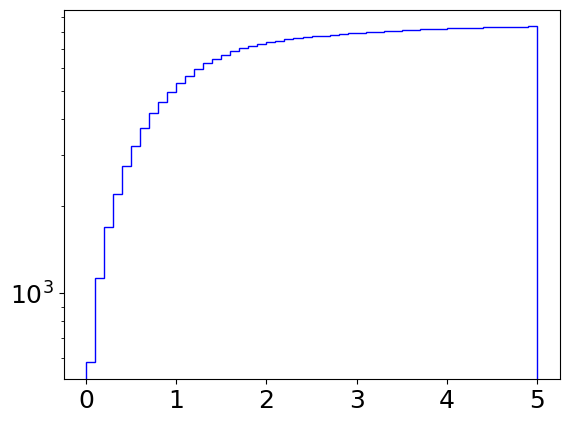

In [12]:
#make histogram cumulative
plt.hist(balmer_lis,range=(0,5), bins=50, cumulative=True, histtype='step', label='Cumulative Distribution', color='blue')
plt.yscale('log')